In [ ]:
import torch
from argparse import Namespace
from regressionFlow.models.networks_regression_SDD import HyperRegression

import matplotlib.pyplot as plt
%matplotlib inline

flow_args = Namespace(model_type='PointNet', logprob_type='Laplace', input_dim=1, dims='3-4-2',
                                   latent_dims='256', hyper_dims='128-32', num_blocks=1, latent_num_blocks=1,
                                   layer_type='concatsquash', time_length=0.5, train_T=True, nonlinearity='tanh',
                                   use_adjoint=True, solver='dopri5', atol=1e-05, rtol=1e-05, batch_norm=True,
                                   sync_bn=False, bn_lag=0, root_dir=None, use_latent_flow=False,
                                   use_deterministic_encoder=False,
                                   zdim=1, optimizer='adam', batch_size=1000, lr=0.001, beta1=0.9,
                                   beta2=0.999, momentum=0.9, weight_decay=1e-05, epochs=1000, seed=694754,
                                   recon_weight=1.0, prior_weight=1.0, entropy_weight=1.0, scheduler='linear',
                                   exp_decay=1.0, exp_decay_freq=1, image_size='28x28', data_dir='data/SDD/',
                                   dataset_type='shapenet15k', cates=['airplane'],
                                   mn40_data_dir='data/ModelNet40.PC15k',
                                   mn10_data_dir='data/ModelNet10.PC15k', dataset_scale=1.0, random_rotate=False,
                                   normalize_per_shape=False, normalize_std_per_axis=False, tr_max_sample_points=2048,
                                   te_max_sample_points=2048, num_workers=4, use_all_data=False,
                                   log_name='experiment_regression_flow_toy', viz_freq=1, val_freq=10, log_freq=1,
                                   save_freq=5, no_validation=False, save_val_results=False, eval_classification=False,
                                   no_eval_sampling=False, max_validate_shapes=None, resume_checkpoint=None,
                                   resume_optimizer=False, resume_non_strict=False, resume_dataset_mean=None,
                                   resume_dataset_std=None, world_size=1, dist_url='tcp://127.0.0.1:9991',
                                   dist_backend='nccl', distributed=False, rank=0, gpu=0, evaluate_recon=False,
                                   num_sample_shapes=10, num_sample_points=2048, use_sphere_dist=False,
                                   use_div_approx_train=False, use_div_approx_test=False)


def _get_opt_(params):
    if flow_args.optimizer == 'adam':
        optimizer = torch.optim.Adam(params, lr=flow_args.lr, betas=(flow_args.beta1, flow_args.beta2),
                               weight_decay=flow_args.weight_decay)
    elif flow_args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(params, lr=flow_args.lr, momentum=flow_args.momentum)
    else:
        assert 0, "args.optimizer should be either 'adam' or 'sgd'"
    return optimizer

def plotTheta(theta,loss):
    X = theta.cpu().detach().numpy().reshape(65,5)
    
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)

    plt.plot(X_r[:,0],X_r[:,1],".")
    plt.show()

In [ ]:
flow = HyperRegression(flow_args)
opt = _get_opt_(list(flow.hyper.parameters()) + list(flow.point_cnf.parameters()))

import torch
from regressionFlow.utils import truncated_normal, standard_normal_logprob, standard_laplace_logprob

# flow hypernetwork with kld loss
def experiment_flow1(flow, opt,n):
    support = torch.randn(5,65)
    for i in range(n):
        x = support
        y = flow.sample_gaussian((*x.shape, flow.input_dim), None, flow.gpu)
        opt.zero_grad()
        batch_size = x.size(0)
        x = flow.hyper(x)
        target_networks_weights = flow.point_cnf(y, x, reverse=True).view(*y.size())

        # Loss
        _, delta_log_py = flow.point_cnf(target_networks_weights, x, torch.zeros(batch_size, y.size(1), 1).to(y))
        log_py = standard_normal_logprob(y).view(batch_size, -1).sum(1, keepdim=True)
        delta_log_py = delta_log_py.view(batch_size, y.size(1), 1).sum(1)
        log_px = log_py - delta_log_py

        # policzyc gestosci flowa log p_0(F^{-1}_\theta(w_i) + J
        loss = log_px.mean()

        # policzyc gestosci priora log N(w_i | (0,I))
        size_multivariate = target_networks_weights.flatten().size()[0]
        multivariate_normal_distrib = torch.distributions.MultivariateNormal(
                torch.zeros_like(target_networks_weights.flatten()).to(loss), torch.eye(size_multivariate).to(loss))
        loss_density = multivariate_normal_distrib.log_prob(target_networks_weights.flatten())
        loss = 0.01 * (loss - loss_density)

        # loss = torch.norm(loss)

        if i % 100 == 0 or i == n-1:
            print(loss)
            plotTheta(target_networks_weights,loss)
        loss.backward()
        opt.step()

experiment_flow1(flow,opt,2000)

In [ ]:
flow = HyperRegression(flow_args)
opt = _get_opt_(list(flow.hyper.parameters()) + list(flow.point_cnf.parameters()))

import torch
from regressionFlow.utils import truncated_normal, standard_normal_logprob, standard_laplace_logprob

# flow hypernetwork with norm loss
def experiment_flow2(flow, opt,n):
    support = torch.randn(5,65)
    for i in range(n):
        x = support
        y = flow.sample_gaussian((*x.shape, flow.input_dim), None, flow.gpu)
        opt.zero_grad()
        x = flow.hyper(x)
        target_networks_weights = flow.point_cnf(y, x, reverse=True).view(*y.size())

        loss = torch.norm(torch.flatten(target_networks_weights))

        if i % 100 == 0:
            print(loss)
            plotTheta(target_networks_weights,loss)
        loss.backward()
        opt.step()

experiment_flow2(flow,opt,2000)

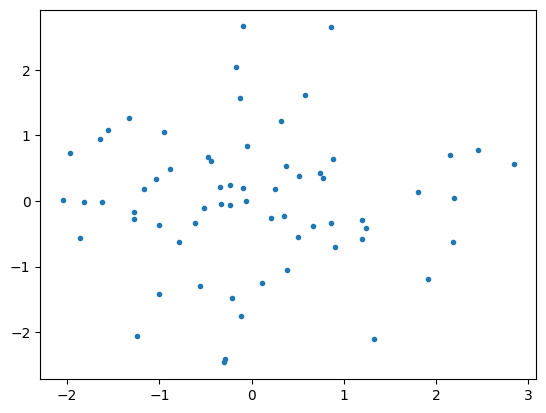

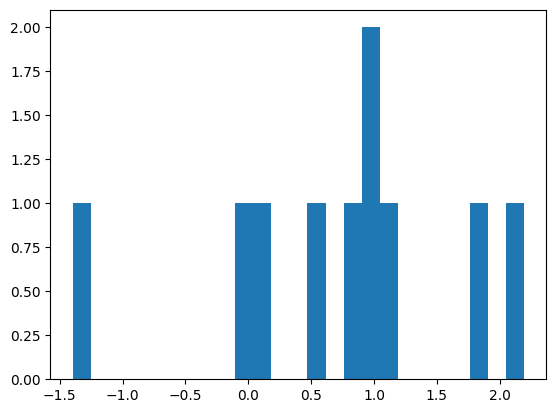

iter no. 0 mu=0.027014758437871933, std=1.049736499786377, loss=38.25019454956055
iter no. 1 mu=0.07765619456768036, std=1.1228294372558594, loss=40.47907257080078


KeyboardInterrupt: 

In [21]:
flow = HyperRegression(flow_args)
opt = _get_opt_(list(flow.hyper.parameters()) + list(flow.point_cnf.parameters()))
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from regressionFlow.utils import truncated_normal, standard_normal_logprob, standard_laplace_logprob
import numpy as np

def plotHist(X, n = 10):
  x = X.cpu().detach().numpy()[:n]
  plt.hist(x, bins = 25)
  plt.show()


def experiment_3(num_iter=1000,do_norm_warmup=False):
    """
    FLOW zwraca kilka zestawow wag do klasyfikatora. Liczymy statystyki na skonkatenowanych zestawach wag, ktore raportujemy
    z kazda iteracja. Funkcja kosztu moze byc z warmupem normowym.
    """
    support = torch.randn(5,65)
    batch_size = support.size(0)
    
    def get_sample_weights(num_samples=10) -> list[torch.tensor]:
        """zwraca kilka zestawow wag z flowa"""
        weights = torch.empty(0).to('cuda')
        for _ in range(num_samples):
            y = flow.sample_gaussian((*support.shape, flow.input_dim), None, flow.gpu)
            x = flow.hyper(support)
            target_networks_weights = flow.point_cnf(y, x, reverse=True).view(*y.size())
            weights = torch.cat((weights, target_networks_weights.flatten()))
        return weights

    def get_sample_weights_loss(num_samples=10) -> (list[torch.tensor],list[torch.tensor]):
        """zwraca kilka zestawow wag z flowa i ich lossy"""
        weights = torch.empty(0).to('cuda')
        _loss = None
        for _ in range(num_samples):
            y = flow.sample_gaussian((*support.shape, flow.input_dim), None, flow.gpu)
            x = flow.hyper(support)
            target_networks_weights = flow.point_cnf(y, x, reverse=True).view(*y.size())
            weights = torch.cat((weights, target_networks_weights.flatten()))

            # loss
            _, delta_log_py = flow.point_cnf(target_networks_weights, x, torch.zeros(batch_size, y.size(1), 1).to(y))
            log_py = standard_normal_logprob(y).view(batch_size, -1).sum(1, keepdim=True)
            delta_log_py = delta_log_py.view(batch_size, y.size(1), 1).sum(1)
            log_px = log_py - delta_log_py
            # policzyc gestosci flowa log p_0(F^{-1}_\theta(w_i) + J
            loss = log_px.mean()
            # policzyc gestosci priora log N(w_i | (0,I))
            size_multivariate = target_networks_weights.flatten().size()[0]
            multivariate_normal_distrib = torch.distributions.MultivariateNormal(
                    torch.zeros_like(target_networks_weights.flatten()).to(loss), torch.eye(size_multivariate).to(loss))
            loss_density = multivariate_normal_distrib.log_prob(target_networks_weights.flatten())
            loss = 0.01 * (loss - loss_density)
            if _loss is None:
                _loss = loss
            else:
                _loss = _loss + loss

        return weights, torch.mean(_loss)

    def get_weights_stats(weights_samples) -> (float,float):
        """zwraca srednia i std z probki wag flowa do klasyfikatora"""
        mean = torch.mean(weights_samples)
        std = torch.std(weights_samples)
        return mean,std

    def forward_experiment(norm_warmup=10):
        for i in range(num_iter):
            opt.zero_grad()

            if i <= norm_warmup and do_norm_warmup:
                weights = get_sample_weights()
            else:
                weights, loss = get_sample_weights_loss()
            
            target_network_weights = weights
            mean, std = get_weights_stats(target_network_weights)

            if i <= norm_warmup and do_norm_warmup:
                loss = torch.norm(torch.flatten(target_network_weights))

            if i % 100 == 0:
                plotTheta(target_network_weights[:325],loss)
                plotHist(target_network_weights)
            print(f"iter no. {i} mu={mean}, std={std}, loss={loss}")
            loss.backward()
            opt.step()
    forward_experiment()

experiment_3()
